### **1. Importing Libraries**

In [25]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

### **2. Importing Data**

In [26]:
students_data_train = pd.read_csv('./data/train.csv')
students_data_train.head(10)

,Student_ID,Age,Gender,Degree,Branch,CGPA,Internships,Projects,Coding_Skills,Communication_Skills,Aptitude_Test_Score,Soft_Skills_Rating,Certifications,Backlogs,Placement_Status
0,1048,22,Female,B.Tech,ECE,6.29,0,3,4,6,51,5,1,3,Not Placed
1,37820,20,Female,BCA,ECE,6.05,1,4,6,8,59,8,2,1,Not Placed
2,49668,22,Male,MCA,ME,7.22,1,4,6,6,58,6,2,2,Not Placed
3,19467,22,Male,MCA,ME,7.78,2,4,6,6,90,4,2,0,Placed
4,23094,20,Female,B.Tech,ME,7.63,1,4,6,5,79,6,2,0,Placed
5,8710,20,Male,BCA,ECE,7.99,1,4,5,7,84,6,2,0,Placed
6,24363,21,Male,MCA,ECE,7.50,1,4,6,4,71,8,2,1,Not Placed
7,27448,19,Male,B.Tech,ME,8.00,0,4,4,5,74,3,1,0,Not Placed
8,23663,24,Male,BCA,Civil,6.24,0,3,3,10,54,7,1,2,Not Placed
9,39336,23,Male,B.Sc,ME,7.08,2,4,7,6,59,6,2,2,Not Placed


### **3. Exploratory Data Analysis (EDA)**

In [27]:
students_data_train.shape

(45000, 15)

In [28]:
students_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Student_ID            45000 non-null  int64  
 1   Age                   45000 non-null  int64  
 2   Gender                45000 non-null  object 
 3   Degree                45000 non-null  object 
 4   Branch                45000 non-null  object 
 5   CGPA                  45000 non-null  float64
 6   Internships           45000 non-null  int64  
 7   Projects              45000 non-null  int64  
 8   Coding_Skills         45000 non-null  int64  
 9   Communication_Skills  45000 non-null  int64  
 10  Aptitude_Test_Score   45000 non-null  int64  
 11  Soft_Skills_Rating    45000 non-null  int64  
 12  Certifications        45000 non-null  int64  
 13  Backlogs              45000 non-null  int64  
 14  Placement_Status      45000 non-null  object 
dtypes: float64(1), int6

In [29]:
students_data_train.isna().sum()

Student_ID              0
Age                     0
Gender                  0
Degree                  0
Branch                  0
CGPA                    0
Internships             0
Projects                0
Coding_Skills           0
Communication_Skills    0
Aptitude_Test_Score     0
Soft_Skills_Rating      0
Certifications          0
Backlogs                0
Placement_Status        0
dtype: int64

array([[<Axes: title={'center': 'Student_ID'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'CGPA'}>],
       [<Axes: title={'center': 'Internships'}>,
        <Axes: title={'center': 'Projects'}>,
        <Axes: title={'center': 'Coding_Skills'}>],
       [<Axes: title={'center': 'Communication_Skills'}>,
        <Axes: title={'center': 'Aptitude_Test_Score'}>,
        <Axes: title={'center': 'Soft_Skills_Rating'}>],
       [<Axes: title={'center': 'Certifications'}>,
        <Axes: title={'center': 'Backlogs'}>, <Axes: >]], dtype=object)

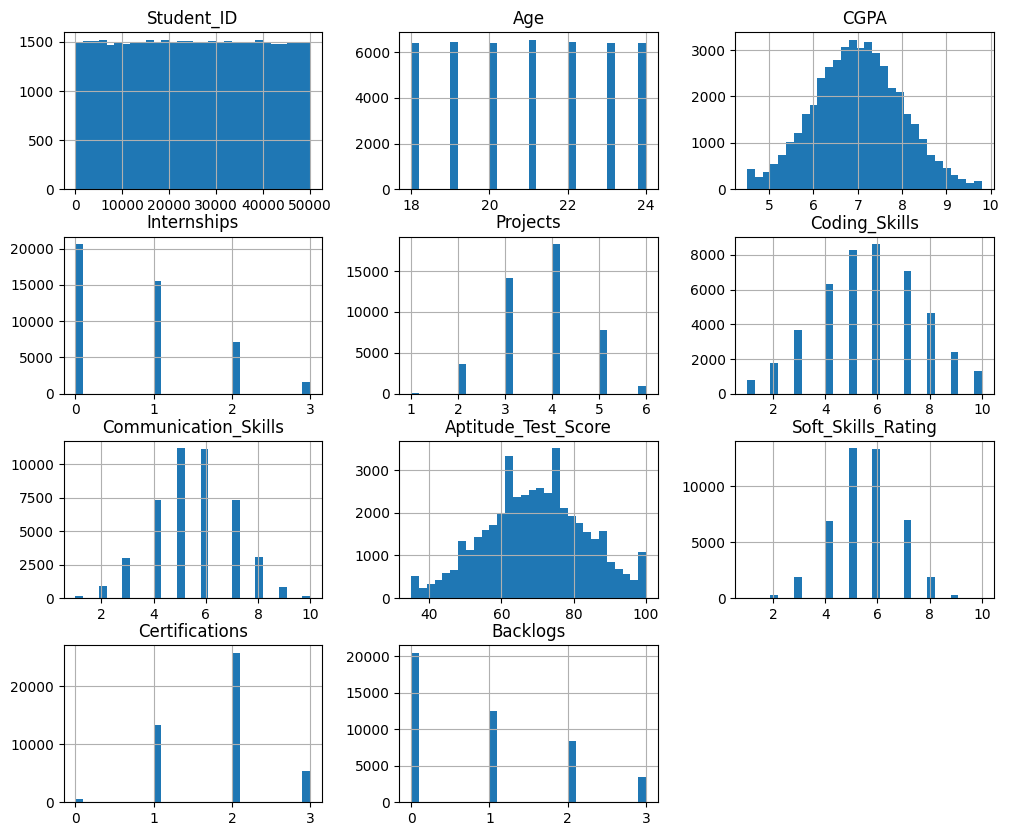

In [30]:
students_data_train.hist(figsize=(12,10), bins=30)

- All the numerical features seems to be in a reasonable range, not obvious outliers.
- Several of them follow a Gaussian distribution
- Be careful, with 2 skewed columns, like Internships and Backlogs

In [31]:
students_data_train['Placement_Status'].value_counts(normalize=True)

Placement_Status
Not Placed    0.637511
Placed        0.362489
Name: proportion, dtype: float64

- Slightly unbalanced target

In [32]:
# Looking for the cardinality of categorical features
categorical_features = students_data_train.select_dtypes(include=['object']).columns.to_list()

for feature in categorical_features:
    print(f"{feature}: {students_data_train[feature].nunique()} unique values")


Gender: 2 unique values
Degree: 4 unique values
Branch: 5 unique values
Placement_Status: 2 unique values


- The categorical features have low to medium cardinality so we can use in this case One Hot Encoding for all of them

### **4. Baseline model**

#### **4.1 Models pipeline**

In [33]:
# Preparing feature matrix X and target vector y for training and testing sets (we have both in separate files)
X_train = students_data_train.drop(columns=['Placement_Status', 'Student_ID'])
y_train = students_data_train['Placement_Status'].apply(lambda x: 1 if x == 'Placed' else 0)

students_data_test = pd.read_csv('./data/test.csv')
X_test = students_data_test.drop(columns=['Student_ID', 'Placement_Status'])
y_test = students_data_test['Placement_Status'].apply(lambda x: 1 if x == 'Placed' else 0)

In [34]:
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_features

['Gender', 'Degree', 'Branch']

In [35]:
# We don't have high cardinality categorical features, so we can use OneHotEncoder
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# We don't have missing values, so we can directly scale numerical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor_linear = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

preprocessor_tree = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_features)
])

In [36]:
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor_linear),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor_tree),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor_tree),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

In [37]:
results = {}

for model_name, model_pipeline in models.items():
    print(f"Training {model_name}...")

    model_pipeline.fit(X_train, y_train)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.35).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

results_df = pd.DataFrame(results).T
results_df

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...


,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.758411,0.895695,0.821356,0.936452
Random Forest,0.398285,0.640728,0.491221,0.561561
Gradient Boosting,0.397634,0.667770,0.498455,0.560588
